## ML Model Development

In [1]:
import pandas as pd
import string
import spacy
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import warnings
import pickle
import os

# General

from structs import BasePreProcessorStep, PreProcessor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, KFold
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor

# NLP

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# ML

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# DL

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from kerastuner.tuners import RandomSearch


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

DATA_PATH = "../data/"
MODEL_PATH = '../models/'
NLTK_PATH = DATA_PATH + '/nltk_data/'

C:\Users\cmgui\AppData\Local\Temp\ipykernel_17432\3445032566.py:53: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# download nltk requirements
nltk.download('punkt', download_dir=NLTK_PATH)
nltk.download('stopwords', download_dir=NLTK_PATH)
nltk.download('wordnet', download_dir=NLTK_PATH)

# load spacy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to ../data//nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../data//nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../data//nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def load_dataframe_indexes():
    with open(DATA_PATH + "indexes.txt", "r") as f:
        indexes = [int(index.strip()) for index in f.readlines()]
        return indexes
    
def execute_preprocessor(steps, df, numerical_cols=[], categorical_cols=[]):
    process = PreProcessor(steps, numerical_cols, categorical_cols)
    process.run(df) # apply preprocess pipeline on df

def save_model(model, name, score, is_tf=False):
    if not is_tf:
        with open(
            MODEL_PATH + F'{name}_{score}.pkl', 
            'wb'
        ) as f:
            pickle.dump(model, f)
    else:
        tf.keras.models.save_model(
            model, 
            MODEL_PATH + F'{name}_{score}.keras', 
            overwrite=True
        )

In [4]:
indexes = load_dataframe_indexes()

tests = pd.read_excel(DATA_PATH + "test_set.xlsx")
df = pd.read_excel(DATA_PATH + "train_set.xlsx").iloc[indexes].reset_index(drop=True)
df.head(3)

,ID,SRC_TITLE_ID,SRC_TITLE_NM,TITLE_TYPE,TITLE_YR,RELEASE_DT,RUN_TIME,PLOT_OUTLINE,PLOT_MEDIUM,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,SRC_GENRE
0,1,tt7831076,"Yes, Sir! 7",movie,2016,2016-09-02,111.0,NaN,"From 1988 to 2000, Taiwan released six Yes, Si...","From 1988 to 2000, Taiwan released six Yes, Si...",1.4,127,NaN,Comedy
1,2,tt14746344,ReSet,movie,2022,2023-07-02,89.0,A college student passes out at a party and wa...,Danielle is your average college student getti...,A college student passes out at a party and wa...,4.3,71,35000.0,Horror
2,3,tt15670842,The Sword,movie,2021,2021-10-18,106.0,"In the ancient times, the Demon King, who was ...",NaN,"In the ancient times, the Demon King, who was ...",4.7,9,NaN,Action


### Base Pre-processing

In [5]:
class RemoveColumns(BasePreProcessorStep):
    def __init__(self, columns):
        self.columns = columns
        pass

    def fit_transform(self, df, numerical_cols, categorical_cols):
        df.drop(columns=self.columns, inplace=True)
        return df

In [6]:
class FillSummary(BasePreProcessorStep):
    """
    This pre-processing step is responsable for filling the SUMMARY
    column with the values of PLOT_MEDIUM, PLOT_OUTLINE, in case
    it's null.
    """
    def __init__(self):
        pass

    def fit_transform(self, df, numerical_cols, categorical_cols):
        df.loc[df['PLOT_SUMMARY'].isnull(), 'PLOT_SUMMARY'] = df['PLOT_MEDIUM']
        df.loc[df['PLOT_SUMMARY'].isnull(), 'PLOT_SUMMARY'] = df['PLOT_OUTLINE']
        return df    

In [7]:
class NaturalLanguageProcessing(BasePreProcessorStep):
    def __init__(self, apply_stemming=False, apply_lemmatization=True):
        self.apply_stemming = apply_stemming
        self.apply_lemmatization = apply_lemmatization
        self.tfidf_vectorizer = None

    def TF_IDF_Vectorization(self, X, max_features=5000):
        tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
        X = tfidf_vectorizer.fit_transform(X).toarray()
        self.tfidf_vectorizer = tfidf_vectorizer
        return X
    
    def TF_IDF_Transform(self, X):
        X = self.tfidf_vectorizer.transform(X).toarray()
        return X
    
    # Tokenization
    def tokenize_text(self, text):
        return word_tokenize(text)
    
    # Remove stopwords
    def remove_stopwords(self, tokens):
        stop_words = set(stopwords.words('english'))
        return [word for word in tokens if word.lower() not in stop_words]
    
    # Stemming
    def stem_tokens(self, tokens):
        porter = PorterStemmer()
        return [porter.stem(word) for word in tokens]
    
    # Lemmatization
    def lemmatize_tokens(self, tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove Punctuation
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    # Apply preprocessing pipeline to 'PLOT_SUMMARY' column
    def preprocess_text(self, text):
        text = self.remove_punctuation(text)
        tokens = self.tokenize_text(text)
        tokens = self.remove_stopwords(tokens)
        if self.apply_stemming: tokens = self.stem_tokens(tokens)
        if self.apply_lemmatization: tokens = self.lemmatize_tokens(tokens)
        return ' '.join(tokens)
    
    def fit_transform(self, df, numerical_cols, categorical_cols):
        df['PLOT_SUMMARY_CLEAN'] = df['PLOT_SUMMARY'].apply(self.preprocess_text) # apply preprocessing to the 'PLOT_SUMMARY' column
        return df          

In [8]:
label_classes = [np.ndarray]

class TargetEncoder(BasePreProcessorStep):
    """
    """
    def __init__(self, column):
        self.column = column

    def fit_transform(self, df, numerical_cols, categorical_cols):
        # Preprocessing for target variable
        encoder = LabelEncoder()
        df[self.column + '_ENCODED'] = encoder.fit_transform(df[self.column])
        label_classes[0] = encoder.classes_
        return df

In [9]:
steps = [
    RemoveColumns(["ID", "SRC_TITLE_ID", "TITLE_TYPE"]),
    FillSummary(),
    NaturalLanguageProcessing(),
    TargetEncoder('SRC_GENRE')
]

execute_preprocessor(steps, df)

In [10]:
df.PLOT_SUMMARY_CLEAN

0        1988 2000 Taiwan released six Yes Sir film exp...
1        college student pass party wake bedroom Edgar ...
2        ancient time Demon King born human grievance s...
3        Haruko single mother unusual living arrangemen...
4        Aqilla aspiration become astronaut grandfather...
                               ...                        
11913    Okka Roju Telugu movie starring Aaditya Reddy ...
11914    7 friend got invited swimming pool engagement ...
11915    Mr Toomey obsessively tear paper control child...
11916    eyeopening documentary dealing cost prescribin...
11917              story top model decides put weight love
Name: PLOT_SUMMARY_CLEAN, Length: 11918, dtype: object

In [11]:
df.SRC_GENRE_ENCODED

0         5
1        12
2         0
3         8
4         2
         ..
11913     8
11914    12
11915     3
11916     7
11917     5
Name: SRC_GENRE_ENCODED, Length: 11918, dtype: int32

In [12]:
label_classes = label_classes[0]
label_classes

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Thriller', 'War', 'Western'], dtype=object)

### Model Baseline

(PLOT_SUMMARY only)

In [13]:
X = df['PLOT_SUMMARY_CLEAN']
y = df['SRC_GENRE_ENCODED']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['SRC_GENRE'])
# ValueError: The least populated class in y has only 1 member, 
# which is too few. The minimum number of groups for any 
# class cannot be less than 2.

tf_idf = NaturalLanguageProcessing()

X = tf_idf.TF_IDF_Vectorization(X)

def evaluate_on_baseline_model(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

    return (
        model, 
        X_train, 
        X_test, 
        y_train, 
        y_test, 
        y_pred
    )

(model, X_train, X_test, y_train, y_test, y_pred) = evaluate_on_baseline_model(X)


Accuracy: 0.5138422818791947
Precision: 0.45908230915122733
Recall: 0.5138422818791947
F1: 0.468990983071026


<span style="color: lightblue; font-size: 14px;">Notes:</span>

- The baseline is classifying based only on Movie Summary (empirically considered the class with the greatest power for classification)
- Acuracy is 51%, which is not bad, considering imbalanced dataset and the number of classes (21 classes)
- Random probability would be 100% / 21 classes = ~5%
- Couldn't stratify the train/test split, due the presence of only 1 member on a class

**Error Analysis**

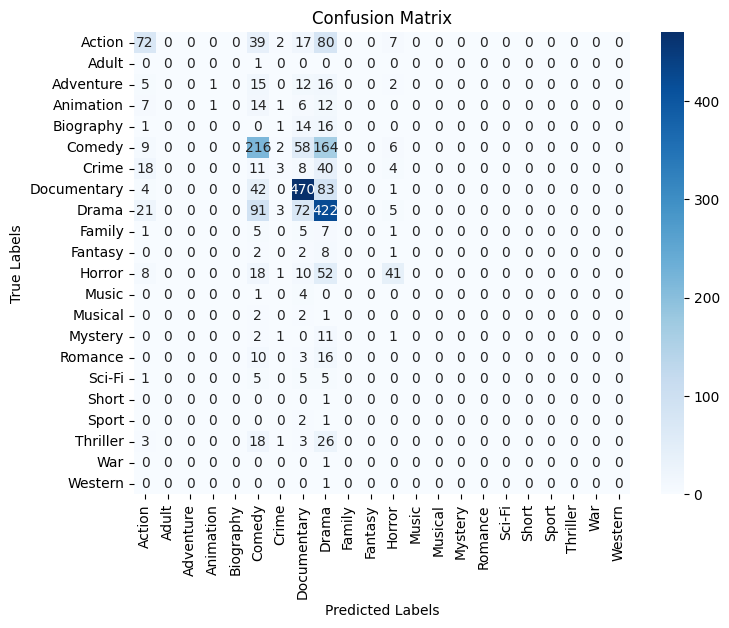

In [14]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
matrix_labels = np.delete(label_classes, 11)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=matrix_labels, yticklabels=matrix_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
src_genre_encoded = y_test.value_counts().reset_index()
src_genre_encoded['SRC_GENRE'] = src_genre_encoded['SRC_GENRE_ENCODED'].apply(lambda x :label_classes[x])
src_genre_encoded[['SRC_GENRE', 'count']]

,SRC_GENRE,count
0,Drama,614
1,Documentary,600
2,Comedy,455
3,Action,217
4,Horror,130
5,Crime,84
6,Adventure,51
7,Thriller,51
8,Animation,41
9,Biography,32


<span style="color: lightblue; font-size: 14px;">Notes:</span>

- The model is mixing a lot the summary of Comedy, Documentary and Drama. This could be explored to identify patterns that could differ the words between this genres.
- The are a lot of genres that doesn't have any predictions, like War, Thriller, Sports. This is compreensible due genre imbalance

### Feature Selection & Engineering

**Add + Relevant Columns ('RATING_AVG', 'NO_OF_VOTES', 'BUDGET_AMT', 'RUN_TIME')**

<span style="color: lightblue; font-size: 14px;">Notes:</span>

- Selected other relevant features, that seems to help on predicting the genre

In [16]:
numerical_cols = ['RATING_AVG', 'NO_OF_VOTES', 'BUDGET_AMT', 'RUN_TIME']

In [17]:
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Assuming X is a DataFrame, you can convert it back to a DataFrame,
    specifing the columns on the constructor 'columns'.
    """
    def __init__(self, columns):
        self.columns = columns
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):              
        return pd.DataFrame(X, columns=self.columns)


In [18]:
num_df = df[numerical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('transformer', DataFrameTransformer(numerical_cols))  # transform back to df
])

num_df = num_pipeline.fit_transform(num_df)

print(num_df)

       RATING_AVG  NO_OF_VOTES  BUDGET_AMT  RUN_TIME
0       -3.297765    -0.125599   -0.122683  0.115672
1       -1.332044    -0.127197   -0.149128 -0.049699
2       -1.060910    -0.128966   -0.122683  0.078088
3       -0.179725    -0.126598   -0.122683  0.063054
4        0.362543    -0.128767   -0.122683  0.040503
...           ...          ...         ...       ...
11913    1.718213    -0.098690   -0.122683  0.190841
11914   -2.009879    -0.127797   -0.122683 -0.042182
11915    0.430327    -0.120834   -0.122683 -0.237621
11916    0.633677    -0.122489   -0.122683 -0.109834
11917   -0.450859    -0.126798   -0.122683 -0.087284

[11918 rows x 4 columns]


In [19]:
to_concat = [df[["PLOT_SUMMARY_CLEAN", "SRC_GENRE_ENCODED"]], num_df]
df_clean = pd.concat(to_concat, axis=1)

In [20]:
df_clean

,PLOT_SUMMARY_CLEAN,SRC_GENRE_ENCODED,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,RUN_TIME
0,1988 2000 Taiwan released six Yes Sir film exp...,5,-3.297765,-0.125599,-0.122683,0.115672
1,college student pass party wake bedroom Edgar ...,12,-1.332044,-0.127197,-0.149128,-0.049699
2,ancient time Demon King born human grievance s...,0,-1.060910,-0.128966,-0.122683,0.078088
3,Haruko single mother unusual living arrangemen...,8,-0.179725,-0.126598,-0.122683,0.063054
4,Aqilla aspiration become astronaut grandfather...,2,0.362543,-0.128767,-0.122683,0.040503
...,...,...,...,...,...,...
11913,Okka Roju Telugu movie starring Aaditya Reddy ...,8,1.718213,-0.098690,-0.122683,0.190841
11914,7 friend got invited swimming pool engagement ...,12,-2.009879,-0.127797,-0.122683,-0.042182
11915,Mr Toomey obsessively tear paper control child...,3,0.430327,-0.120834,-0.122683,-0.237621
11916,eyeopening documentary dealing cost prescribin...,7,0.633677,-0.122489,-0.122683,-0.109834


In [21]:
X_other = df_clean[numerical_cols].to_numpy()

# combine fd-idf matrix with other features
X_combined = np.concatenate((X, X_other), axis=1)

(model, X_train, X_test, y_train, y_test, y_pred) = evaluate_on_baseline_model(X_combined)

Accuracy: 0.5360738255033557
Precision: 0.47237327136643453
Recall: 0.5360738255033557
F1: 0.49050503472891566


In [24]:
save_model(model, "LogisticRegression", "5360")

<span style="color: lightblue; font-size: 14px;">Notes:</span>

- Selected other relevant features, that seems to help on predicting the genre
- Got a higher score of ~54%, increasing 4% from the baseline model

**Outlier Detection and Treatment**

In [25]:
outliers_columns = ['RUN_TIME', 'BUDGET_AMT', 'NO_OF_VOTES']

In [26]:
class OutlierTreatment(BasePreProcessorStep):
    """
    """
    def __init__(self, columns, strategy='lof', indexes=None):
        self.columns = columns
        self.strategy = strategy
        self.indexes = indexes

    def outliers_lof_method(self, df, columns):
        for column in columns:
            X = df[column].values
            lof = LocalOutlierFactor()
            yhat = lof.fit_predict(X.reshape(-1, 1))
            mask = yhat != -1
            non_outlier_df = df.iloc[mask, :]
            print(F'Column: {column}')
            print(F'Identified outliers: {df.shape[0] - non_outlier_df.shape[0]}')
            print(F'Non-outlier observations: {non_outlier_df.shape[0]}')
        return non_outlier_df

    def fit_transform(self, df, numerical_cols, categorical_cols):
        # Preprocessing for target variable
        if self.strategy == 'lof':
            df = self.outliers_lof_method(df, self.columns)
        elif self.strategy == 'handy':
            df = df.drop(indexes)
        return df

In [27]:
execute_preprocessor([OutlierTreatment(outliers_columns)], df_clean)

Column: RUN_TIME
Identified outliers: 149
Non-outlier observations: 11769
Column: BUDGET_AMT
Identified outliers: 306
Non-outlier observations: 11612
Column: NO_OF_VOTES
Identified outliers: 229
Non-outlier observations: 11689


<span style="color: lightblue; font-size: 14px;">Notes:</span>

- Would lose too much information, decided no applying for now

**Add TITLE_YR, RELEASE_DATE**

In [28]:
numerical_cols_2 = numerical_cols + ['TITLE_YR', 'RELEASE_DT']

In [29]:
numerical_cols_2

['RATING_AVG',
 'NO_OF_VOTES',
 'BUDGET_AMT',
 'RUN_TIME',
 'TITLE_YR',
 'RELEASE_DT']

In [30]:
num_df_2 = df[numerical_cols_2].copy()
num_df_2['RELEASE_DT'] = num_df_2['RELEASE_DT'].astype('int64')

num_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('transformer', DataFrameTransformer(numerical_cols_2))  # transform back to df
])

num_df_2 = num_pipeline_2.fit_transform(num_df_2)

print(num_df_2)

       RATING_AVG  NO_OF_VOTES  BUDGET_AMT  RUN_TIME  TITLE_YR  RELEASE_DT
0       -3.297765    -0.125599   -0.122683  0.115672  0.295409    0.143839
1       -1.332044    -0.127197   -0.149128 -0.049699  1.326258    0.385128
2       -1.060910    -0.128966   -0.122683  0.078088  1.154450    0.324951
3       -0.179725    -0.126598   -0.122683  0.063054  1.154450    0.309665
4        0.362543    -0.128767   -0.122683  0.040503  0.810833    0.244650
...           ...          ...         ...       ...       ...         ...
11913    1.718213    -0.098690   -0.122683  0.190841  1.498066    0.387740
11914   -2.009879    -0.127797   -0.122683 -0.042182  0.123601    0.105237
11915    0.430327    -0.120834   -0.122683 -0.237621  1.154450    0.322532
11916    0.633677    -0.122489   -0.122683 -0.109834 -1.079055   -0.132085
11917   -0.450859    -0.126798   -0.122683 -0.087284 -0.391823   -0.000508

[11918 rows x 6 columns]


In [32]:
X_other_2 = num_df_2.to_numpy()

# combine fd-idf matrix with other features
X_combined_2 = np.concatenate((X, X_other_2), axis=1)

(model, X_train, X_test, y_train, y_test, y_pred) = evaluate_on_baseline_model(X_combined_2)

Accuracy: 0.5369127516778524
Precision: 0.481139085375517
Recall: 0.5369127516778524
F1: 0.4919404863774324


<span style="color: lightblue; font-size: 14px;">Notes:</span>

- Score slightly increased

In [33]:
save_model(model, "LogisticRegression", "5369")

### Model Selection

**Machine learning**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "CatBoost": CatBoostClassifier(),
    "Stochastic Gradient": SGDClassifier(random_state=42)   
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

metrics = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted'),  # 'weighted' for multiclass
    "Recall": make_scorer(recall_score, average='weighted'),  # 'weighted' for multiclass
    "F1": make_scorer(f1_score, average='weighted')  # 'weighted' for multiclass
}

# cross-validation for each model
results = {}
for model_name, model in models.items():
    model_results = {}
    for metric_name, metric_func in metrics.items():
        scores = cross_val_score(model, X_combined, y, cv=cv, scoring=metric_func)
        model_results[metric_name] = scores.mean()
    results[model_name] = model_results

In [34]:
# results
for model_name, model_result in results.items():
    print(f"{model_name}:")
    for metric_name, score in model_result.items():
        print(f"{metric_name}: {score:.4f}")
    print()

Logistic Regression:
Accuracy: 0.5223
Precision: 0.4707
Recall: 0.5223
F1: 0.4758

Random Forest:
Accuracy: 0.4852
Precision: 0.4429
Recall: 0.4852
F1: 0.4247

SVM:
Accuracy: 0.4946
Precision: 0.4296
Recall: 0.4946
F1: 0.4359



<span style="color: lightblue; font-size: 14px;">Notes:</span>

- It happens that Logistic Regression (less complex) is scoring better on this problem. This may be due overfitting and imbalance. The second algorith is CatBoost with 52% Accuracy and 48% F1, which is way more complex and difficult to train, so I will keep Logistic for now.
- There is also a problem using cross validation, due a high number of classes that have low samples

**Deep Learning**

In [180]:
# FNN
model = Sequential([
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2310 - loss: 162.1053 - val_accuracy: 0.2576 - val_loss: 2.0530
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2519 - loss: 2.1167 - val_accuracy: 0.2576 - val_loss: 2.0403
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2417 - loss: 2.0859 - val_accuracy: 0.2576 - val_loss: 2.0398
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2640 - loss: 2.0840 - val_accuracy: 0.2517 - val_loss: 2.0371
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2497 - loss: 2.0826 - val_accuracy: 0.2576 - val_loss: 2.0391
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2533 - loss: 2.1010 - val_accuracy: 0.2576 - val_loss: 2.0369
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2585 - loss: 2.0788 - val_accuracy: 0.2576 - val_loss: 2.0374
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2499 - loss: 2.0790 - val_ac

<span style="color: lightblue; font-size: 14px;">Notes:</span>

- val_accuracy is dropping over time, the model is overfitting. Needs to reduce the complexity.

In [120]:
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model.fit(
    X_train, 
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]
)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3350 - loss: 2.1784 - val_accuracy: 0.5256 - val_loss: 1.5446
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5829 - loss: 1.3825 - val_accuracy: 0.5428 - val_loss: 1.4894
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6965 - loss: 1.0652 - val_accuracy: 0.5252 - val_loss: 1.6027
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7885 - loss: 0.7229 - val_accuracy: 0.5122 - val_loss: 1.7704
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8558 - loss: 0.5247 - val_accuracy: 0.4904 - val_loss: 2.0285


<span style="color: lightblue; font-size: 14px;">Notes:</span>

- Now the current best model is this FNN, with 54.31% Accuracy.

### Hyperparameter Tunning

In [114]:
# build model dynamically for RandomrSearch
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.5, max_value=0.7, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=64, max_value=512, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.5, max_value=0.7, step=0.1)))
    model.add(Dense(len(label_classes), activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tunning',
    project_name='FNN'
)

# search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test))

# best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.5377516746520996

Best val_accuracy So Far: 0.5486577153205872
Total elapsed time: 00h 03m 36s
Best Hyperparameters:
{'units_1': 384, 'dropout_1': 0.6, 'units_2': 128, 'dropout_2': 0.5}


<span style="color: lightblue; font-size: 14px;">Notes:</span>

- Increased the Droput ceiling and reduced model hidden layers to decrease complexity 

In [130]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping]) # train
save_model(best_model, 'FNN', '5486', is_tf=True)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3365 - loss: 2.2871 - val_accuracy: 0.5025 - val_loss: 1.5887
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5342 - loss: 1.5552 - val_accuracy: 0.5445 - val_loss: 1.4867
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6490 - loss: 1.2556 - val_accuracy: 0.5344 - val_loss: 1.5223


### Final Inference

In [123]:
tests = pd.read_excel(DATA_PATH + "test_set.xlsx")

In [132]:
def list_models():
    files = []
    for dirname, _, filenames in os.walk(MODEL_PATH):
        for filename in filenames:
            file = {
                'path': os.path.join(dirname, filename),
                'score': filename.split(".")[0][-4:],
                'ext': filename.split(".")[1]
            }
            files.append(file)
    return files

def load_best_model():
    models = list_models()
    best = max(models, key=lambda x: x['score'])
    print(best)
    if best['ext'] in ['keras', 'h5']:
       model = load_model(best['path'])
    else:
       with open(best['path'], 'rb') as f:
           model = pickle.load(f)
    return model

def model_predict(model, test_df, final_df):
    predictions = model.predict(test_df)
    y_pred = np.argmax(predictions, axis=1)
    final_df["SRC_GENRE_PREDICTED"] = np.array(list(map(lambda x: label_classes[x], y_pred)))
    return final_df

def save_predictions(final_df):
    final_df.to_excel(DATA_PATH + "test_predictions.xlsx", index=False)

In [134]:
model = load_best_model()

{'path': '../models/FNN_5486.keras', 'score': '5486', 'ext': 'keras'}


In [136]:
def test_submission_pipeline(test, tf_idf):
    test_df = test.copy()
    test_steps = [
        FillSummary(), 
        NaturalLanguageProcessing()
    ]
    execute_preprocessor(test_steps, test_df)
    test_num_df = test_df[numerical_cols]
    test_num_df = num_pipeline.fit_transform(test_num_df[numerical_cols])
    test_summary_df = tf_idf.TF_IDF_Transform(test_df["PLOT_SUMMARY_CLEAN"])
    test_X_combined = np.concatenate((test_summary_df, test_num_df), axis=1)

    return test_X_combined

test_df_preprocessed = test_submission_pipeline(tests, tf_idf)
test_df_preprocessed

array([[ 0.        ,  0.        ,  0.        , ..., -0.11896356,
        -0.12389325,  0.3941144 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.13662977,
        -0.1495308 , -0.35555501],
       [ 0.        ,  0.        ,  0.        , ..., -0.12740197,
        -0.14875911,  0.4357627 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.083985  ,
        -0.0853083 , -0.14731351],
       [ 0.        ,  0.        ,  0.        , ..., -0.13344496,
        -0.12389325, -0.10566521],
       [ 0.        ,  0.        ,  0.        , ..., -0.13526874,
        -0.12389325,  0.893894  ]])

In [137]:
tests = model_predict(model, test_df_preprocessed, tests)
save_predictions(tests)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [138]:
tests.head(3)

,ID,SRC_TITLE_ID,SRC_TITLE_NM,TITLE_TYPE,TITLE_YR,RELEASE_DT,RUN_TIME,PLOT_OUTLINE,PLOT_MEDIUM,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,SRC_GENRE_PREDICTED
0,68001,tt10691314,Are We Lost Forever,movie,2020,2020-01-12,104.0,One morning it is over. For Hampus it is a rel...,Painful breakups and loving meetings in an int...,One morning it is over. For Hampus it is a rel...,5.5,666,NaN,Drama
1,68002,tt13871408,Sweet Mahogany 2: Pure Indulgence,movie,2021,2021-02-23,86.0,NaN,Mahogany Andrews appears to be in the fight fo...,Mahogany Andrews appears to be in the fight fo...,5.9,17,1000.0,Drama
2,68003,tt1234430,Between Something & Nothing,movie,2008,2008-05-21,105.0,"Joe,a freshman art school student, befriends J...","With the impressive """"Between Something & Noth...","Joe,a freshman art school student, befriends J...",4.9,356,10000.0,Drama
